In [88]:
# get openai api key from openai_config.json file
import json
with open('openai_config.json') as f:
    openai_api_key = json.load(f)['openai_api_key']

In [89]:
%%capture

%env OPENAI_API_KEY = {openai_api_key}


In [90]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [91]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings

# For English: HuggingFace Embedding
embeddings_eng = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# For Korean: OpenAI Embedding
embeddings_kor = OpenAIEmbeddings(model="text-embedding-3-large")

In [92]:
from langchain.document_loaders import CSVLoader

# Loader for the HS code dataset
loader_kor = CSVLoader(r"../guidance_for_environmental_impact_factor_mapping_on_aws/assets/datasets/Korean_HSCode_kor_6digits.csv")
# loader_eng = CSVLoader(r"../guidance_for_environmental_impact_factor_mapping_on_aws/assets/datasets/Korean_HSCode_eng.csv")

In [93]:
# documents_eng = loader_eng.load()
documents_kor = loader_kor.load()

In [94]:
# # 첫 번째 실행에서만!!!
from langchain_community.vectorstores import FAISS

# Make FAISS vectorstore
# vector_store_eng = FAISS.from_documents(documents_eng, embeddings_eng)

# save db to local (UN의 HSCode db랑 구분하기 위해 KORHS를 붙임)

In [95]:
# Make FAISS vectorstore- kor
vector_store_kor = FAISS.from_documents(documents_kor, embeddings_kor)

# save db to local (UN의 HSCode db랑 구분하기 위해 KORHS를 붙임)
vector_store_kor.save_local('./db/faiss_KORHS_kor_6digits')

In [114]:
# Load the DB from local
# 두 번째 실행부터는 위 셀 실행하지 않고 이 셀만 실행
from langchain_community.vectorstores import FAISS

# vector_store_eng = FAISS.load_local(
#     folder_path="./db/faiss_KORHS_eng",
#     index_name="index",
#     embeddings=embeddings_eng,
#     allow_dangerous_deserialization=True,
# )

vector_store_kor = FAISS.load_local(
    folder_path="./db/faiss_KORHS_kor_6digits",
    index_name="index",
    embeddings=embeddings_kor,
    allow_dangerous_deserialization=True,
)

In [97]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    activity: str
    clean_desc: str
    best3: List[Document]
    answer: str

In [98]:
from langchain_core.prompts import PromptTemplate

# Prompt to choose the best emission factor from the options
best_eif_prompt_ENG = """You are a Lifecycle Analysis expert matching grocery products to their Harmonized System (HS) Codes.

I want to do of LCA of grocery products based on Environmentally Extended Input Output (EEIO) Environmental Impact Factors (EIF). I am interested in the environmental impact associated with the materials and manufacturing phase of the product. I am given a grocery product and three possible corresponding HS codes and descriptions. 

I want to pick the HS code and description that best match the given product. Include justification for your choice.
Format the output in JSON with the keys BestHSCode, BestHSDescription, Justification.

Product:
{clean_desc}

Possible HS codes and titles:
{best3}

Which of these HS Codes is the best match for the provided product? 

Make the most of the given information. DO NOT say that information is limited or ask for more information.
YOU MUST choose a best code and title. YOU MUST include a justification for your choice.
Avoid filler words such as "Based on the details" or "happy to assist", keep your response to the point.
Do not repeat the given instructions or information. 
DO NOT say you have insufficient information for an LCA.

Respond with the JSON output and nothing else.
"""

best_eif_prompt_KOR = """너는 식료품을 HS 코드로 분류하는 전과정영향평가(Life Cycle Analysis, LCA) 전문가야.

나는 환경 확장 투입 산출(Environmentally Extended Input Output, EEIO) 환경 영향 계수(Environmental Impact Factors, EIF)를 기반으로 한 식료품의 전과정영향평가를 수행하고 싶어. 나는 식료품의 재료 및 제조 단계와 관련된 환경적 영향에 관심 있어. 나는 하나의 물품과 이에 해당할 가능성이 있는 세 가지 HS 코드 및 항목명을 받았어.

나는 주어진 물품에 가장 적합한 HS 코드와 항목명을 선택하고 싶어. 선택에 대한 근거를 함께 설명해야 해.
출력 형식은 JSON으로, 키는 "가장_적합한_HS_코드", "가장_적합한_HS_항목명", "판단_근거"야.

물품:
{clean_desc}

가능한 HS 코드 및 항목명:
{best3}

다음 중 제공된 물품과 가장 적합한 HS 코드는 무엇이지?

주어진 정보를 최대한 활용해. 정보가 제한되어 있다고 말하거나 추가 정보를 요청하지 마.
가장 적합한 코드와 항목명 선택해야 해. 선택에 대한 근거를 반드시 포함해야 해.
“세부 사항에 따라” 또는 ‘기꺼이 도와드리겠습니다’와 같은 미사여구는 피하고 요점에 집중하여 답변해.
주어진 지침이나 정보를 반복하지 마.
전과정영향평가에 필요한 정보가 충분하지 않다고 말하지 마.
다른 말 없이 JSON 출력으로만 응답해."""

best_eif_prompt_ENG = PromptTemplate.from_template(best_eif_prompt_ENG)
best_eif_prompt_KOR = PromptTemplate.from_template(best_eif_prompt_KOR)


In [132]:
# Prompt to clean activity names and descriptions into a simple activity description to be matched in the next step.
clean_text_prompt_ENG = """I want to do of LCA of grocery products based on Environmentally Extended Input Output (EEIO) 
Environmental Impact Factors (EIF). I am interested in the environmental impact associated with the materials 
and manufacturing phase of the product. I am given grocery product names, and I want to 
paraphrase it to a plain language description before I select an EIF. 

Below is an example, inside <example></example> XML tags, of a given product name, and its plain language descriptions. Note that the descriptions 
are brief, and do not make any assumptions about the product.

<example>
PRODUCT_NAME            Gloves Work Mechanic Synthetic Leather SZ Large

The item is a synthetic leather large work gloves 
</example>

Following the example, provide a plain language description of the product data given below:
{activity}

Make the most of the given information. DO NOT say that information is limited.
DO NOT refrain from providing a description, or ask for more information.
If you cannot provide a plain language description, simply summarize the 
information provided. You MUST provide a description. 
DO NOT include the xml tags in your response.

Avoid filler words such as "Based on the details" or "happy to assist", 
keep your response to the point.
Do not repeat the given instructions or information. 
DO NOT say you have insufficient information for an LCA.

Only provide the description and nothing else."""

clean_text_prompt_KOR = """나는 환경 확장 투입 산출(Environmentally Extended Input Output, EEIO) 환경 영향 요인(Environmental Impact Factors, EIF)을 기반으로 한 식료품의 전과정영향평가(LCA)를 수행하려고 해. 
나는 식료품의 재료 및 제조 단계와 관련된 환경적 영향을 알고 싶어. 나는 식료품의 품목명을 받았고, 
이를 평이한 언어로 바꾸어 다시 서술한 후에 환경 영향 요인을 선택하려고 해.

아래는 <example></example> XML 태그 안에 제공된 품목명과 그 평이한 언어 설명의 예시야. 
설명은 간결하며, 활동에 대한 어떠한 가정도 포함하지 않는다는 점을 주목해.

<example>  
품목명                                     뉴발란스 야구화, 500g, 2개  

이 품목은 신발로, 합성 가죽으로 만든 야구용 신발입니다. 500g이며 2개가 포함되어 있습니다.

</example>  

위 예시를 참고하여, 아래에 제공된 식료품 데이터를 평이한 언어로 설명해:  
{activity}  

제공된 정보를 최대한 활용해. 정보가 제한적이라고 말하지 마.  
설명을 제공하지 않거나 추가 정보를 요청하지 마.
평이한 언어 설명을 제공할 수 없는 경우, 단순히 제공된 정보를 요약해. 반드시 설명을 제공해야 해. 
XML 태그는 응답에 포함하지 마. 

"세부 사항에 따르면" 또는 "도움을 드릴 수 있어 기쁩니다"와 같은 군더더기 표현을 피하고, 응답을 간결하게 작성해.  
주어진 지침이나 정보를 반복하지 마.  
전과정영향평가에 대해 정보가 부족하다고 언급하지 마.  

설명만 제공하고, 그 외에는 아무것도 작성하지 마."""

clean_text_prompt_ENG = PromptTemplate.from_template(clean_text_prompt_ENG)
clean_text_prompt_KOR = PromptTemplate.from_template(clean_text_prompt_KOR)


In [100]:
def clean_eng(state: State):
    messages = clean_text_prompt_ENG.invoke({"activity": state["activity"]})
    response = llm.invoke(messages)
    return {"clean_desc": response.content}

def retrieve_eng(state: State):
    clean_desc = state["clean_desc"]
    best3_prompt_text = f"What are three possible HS Codes for the given product description: {clean_desc}"
    retrieved_docs = vector_store_eng.similarity_search(best3_prompt_text, 3) # 3
    return {"best3": retrieved_docs}


def generate_eng(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["best3"])
    messages = best_eif_prompt_ENG.invoke({"clean_desc": state["clean_desc"], "best3": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [133]:
def clean_kor(state: State):
    messages = clean_text_prompt_KOR.invoke({"activity": state["activity"]})
    response = llm.invoke(messages)
    return {"clean_desc": response.content}

def retrieve_kor(state: State):
    clean_desc = state["clean_desc"]
    best3_prompt_text = f"다음 품목에 해당할 가능성이 가장 높은 세 가지 HS 코드 및 항목명은?: {clean_desc}"
    retrieved_docs = vector_store_kor.similarity_search(best3_prompt_text, 3) # 3
    return {"best3": retrieved_docs}


def generate_kor(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["best3"])
    messages = best_eif_prompt_KOR.invoke({"clean_desc": state["clean_desc"], "best3": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [134]:
from langgraph.graph import START, StateGraph

# graph_builder_eng = StateGraph(State).add_sequence([clean_eng, retrieve_eng, generate_eng])
# graph_builder_eng.add_edge(START, "clean_eng")
# graph_eng = graph_builder_eng.compile()

graph_builder_kor = StateGraph(State).add_sequence([clean_kor, retrieve_kor, generate_kor])
graph_builder_kor.add_edge(START, "clean_kor")
graph_kor = graph_builder_kor.compile()

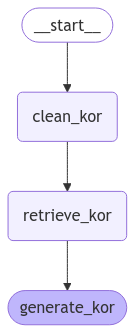

In [126]:
from IPython.display import Image, display

display(Image(graph_kor.get_graph().draw_mermaid_png()))

In [ ]:
# Loader for the input activities dataset
from langchain.document_loaders import CSVLoader

input_loader_eng = CSVLoader(r"../guidance_for_environmental_impact_factor_mapping_on_aws/assets/input/coupang_product_names_groceries_v3_eng.csv", encoding='utf-8-sig')
input_doc_eng = input_loader_eng.load()

input_doc_eng[0].page_content

'PRODUCT_NAME: Oatmeal White Rice, 210 g, 24 packets'

In [135]:
input_loader_kor = CSVLoader(r"../guidance_for_environmental_impact_factor_mapping_on_aws/assets/input/coupang_product_names_groceries_v3_kor.csv", encoding='utf-8-sig')
input_doc_kor = input_loader_kor.load()

input_doc_kor[0].page_content

'품목명: 오뚜기 흰밥, 210g, 24개'

In [ ]:
import re  # For extracting fields from page_content

# Initialize results storage
results_eng = []

# Process each row using the graph
for doc in input_doc_eng:
    # # Extract CommodityDescription from the page_content using regex
    # match = re.search(r"CommodityDescription: (.+)", doc.page_content)
    # activity = match.group(1).strip() if match else None  # Extract the description

    activity = doc.page_content # Extract the Product Name

    if activity:
        # print(f"Processing activity: {activity}")  # Debugging: print the activity
        # Invoke the graph
        result = graph_eng.invoke({"activity": activity})
        
        # Extract context and answer from the state after processing
        results_eng.append({
            "ProductName": activity,
            "CleanDescription": result.get("clean_desc", ""),
            "Best3": "\n".join(doc.page_content for doc in result.get("best3", "")),
            "Answer": result.get("answer", "")
        })

# Print the results for debugging
print("Final results:", results_eng)

Final results: [{'ProductName': 'PRODUCT_NAME: Oatmeal White Rice, 210 g, 24 packets', 'CleanDescription': 'The product is a package of oatmeal white rice containing 24 individual packets, with a total weight of 210 grams.', 'Best3': 'HSCode: 1901909010\nDescription: Food preparations; flour, meal, starch, malt extract or dairy products, except for uses described in heading no. 1901; Miscellaneous; Oatmeal\nHSCode: 1006400000\nDescription: Grain; rice, broken; broken rice\nHSCode: 1006100000\nDescription: grain; hulled rice (rice or coarse rice); rice', 'Answer': '```json\n{\n  "BestHSCode": "1901909010",\n  "BestHSDescription": "Food preparations; flour, meal, starch, malt extract or dairy products, except for uses described in heading no. 1901; Miscellaneous; Oatmeal",\n  "Justification": "The product is a package of oatmeal white rice, which includes oatmeal as a key ingredient. The HS code 1901909010 specifically pertains to food preparations that include oatmeal, making it the mos

In [136]:
# Initialize results storage
results_kor = []

# Process each row using the graph
for doc in input_doc_kor[:30]:
    # # Extract CommodityDescription from the page_content using regex
    # match = re.search(r"CommodityDescription: (.+)", doc.page_content)
    # activity = match.group(1).strip() if match else None  # Extract the description

    activity = doc.page_content # Extract the Product Name

    if activity:
        result = graph_kor.invoke({"activity": activity})
        
        # Extract context and answer from the state after processing
        results_kor.append({
            "ProductName": activity,
            "CleanDescription": result.get("clean_desc", ""),
            "Best3": "\n".join(doc.page_content for doc in result.get("best3", "")),
            "Answer": result.get("answer", "")
        })

# Print the results for debugging
print("Final results:", results_kor)

Final results: [{'ProductName': '품목명: 오뚜기 흰밥, 210g, 24개', 'CleanDescription': '이 품목은 즉석으로 조리된 흰 쌀밥으로, 210g의 포장이 24개 포함되어 있습니다.', 'Best3': '코드: 100640\n설명: 곡물; 쌀, 깨진; 쇄미(broken rice)\n코드: 110630\n설명: 밀가루, 식사 및 분말; 8장의 제품 중; 제8류 물품의 것\n코드: 100610\n설명: 곡물; 껍질째 먹는 쌀(벼 또는 거친 쌀); 벼', 'Answer': '```json\n{\n  "가장_적합한_HS_코드": "100640",\n  "가장_적합한_HS_항목명": "곡물; 쌀, 깨진; 쇄미(broken rice)",\n  "판단_근거": "즉석으로 조리된 흰 쌀밥은 쌀을 기본 원료로 사용하므로, 쌀과 관련된 HS 코드가 가장 적합하다. 100640 코드는 깨진 쌀을 포함하지만, 즉석 조리된 쌀밥의 재료는 일반적으로 깨진 쌀을 사용할 수 있어 이 코드가 적합하다. 다른 두 코드는 쌀이 아닌 밀가루와 벼에 해당하므로 선택에서 제외된다."\n}\n```'}, {'ProductName': '품목명: 신라면 120g, 30개', 'CleanDescription': '이 품목은 신라면으로, 120g짜리 봉지가 30개 들어 있습니다.', 'Best3': '코드: 110630\n설명: 밀가루, 식사 및 분말; 8장의 제품 중; 제8류 물품의 것\n코드: 110610\n설명: 밀가루, 식사 및 분말; 제목의 말린 콩과 식물성 채소 중 번호. 0713; 건조한 채두류(菜豆類)의 것(제0713호의 것으로 한정한다)\n코드: 190230\n설명: 음식 준비물; 파스타(박제 제외), 조리 또는 기타 조리된 음식; 인스탄트 면류;라면, 기타, 기타', 'Answer': '```json\n{\n  "가장_적합한_HS_코드": "190230",\n  "가장_적합한_HS_항목명": "음식 준비물; 파스타(박제 제외), 조리 또는 기타 

In [ ]:
# Save results to a CSV file
import csv
from datetime import datetime

# Get the current date and time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

# Create a unique file name with date and time!!
file_name_eng = f"results/coupang_result_v3_eng_{timestamp}.csv"

with open(file_name_eng, "w", newline="") as csvfile:
    fieldnames = ["ProductName", "CleanDescription", "Best3", "Answer"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(results_eng)

print("Results saved to {file_name_eng}")

Results saved to {file_name}


In [137]:
# Get the current date and time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

# Create a unique file name with date and time!!
file_name_kor = f"results/coupang_result_v3_kor_{timestamp}_baseball_prompt.csv"

with open(file_name_kor, "w", newline="") as csvfile:
    fieldnames = ["ProductName", "CleanDescription", "Best3", "Answer"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(results_kor)

print("Results saved to {file_name_kor}")

Results saved to {file_name_kor}
